In [1]:
import pandas as pd
from sqlalchemy import create_engine

# In die Datei const.py müssen die Zugangsdaten eingetragen werden
import const as c

In [2]:
engine = create_engine(
    f'postgresql://{c.pg_userid}:{c.pg_password}@{c.pg_host}/{c.pg_db}', 
    connect_args = {'options': '-c search_path=uadbkt,uccfraud', 'keepalives_idle': 120},
    pool_size=1, 
    max_overflow=0,
    execution_options={ 'isolation_level': 'AUTOCOMMIT' }
)

In [3]:
# engine.dispose()

### AnzahlDS pro Jahr, prozentualer Anteil pro Jahr

In [4]:
sql ="""
with
  base1(jahr, anz_jahr, anz_gesamt, anteil_pro_jahr) as (
    select 
      extract(year from ts), 
      count(*),
      sum(count(*)) over (),
      (cast(count(*) as float) / sum(count(*)) over ()) * 100
    from ccfraud2010
    group by extract(year from ts)
  )
select
  jahr as "jahr",
  anz_jahr as "anz_jahr",
  anz_gesamt as "anz_gesamt",
  anteil_pro_jahr as "anteil_pro_jahr"
from base1
order by jahr
"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
    data_pdf.jahr = data_pdf.jahr.astype('int32')
    data_pdf.set_index('jahr', inplace = True)
    
data_pdf

anz_jahr  anz_gesamt  anteil_pro_jahr
jahr                                       
2010   1491225  16575073.0         8.996793
2011   1570551  16575073.0         9.475379
2012   1610829  16575073.0         9.718383
2013   1650917  16575073.0         9.960240
2014   1672343  16575073.0        10.089506
2015   1701371  16575073.0        10.264637
2016   1708924  16575073.0        10.310205
2017   1723360  16575073.0        10.397300
2018   1721615  16575073.0        10.386772
2019   1723938  16575073.0        10.400787

<AxesSubplot:title={'center':'Verteilung'}, xlabel='jahr', ylabel='prozent'>

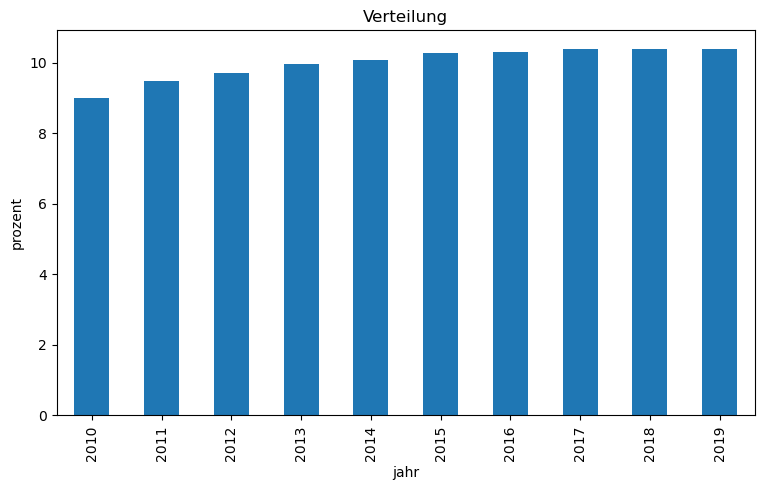

In [5]:
title = 'Verteilung'
xlabel = 'jahr'
ylabel='prozent'
data_pdf['anteil_pro_jahr'].plot.bar(figsize=(9,5), title=title, xlabel=xlabel, ylabel=ylabel)

### AnzahlDS Ok/Betrug, prozentualer Anteil

In [6]:
sql ="""
with
  base1(is_fraud, anz, anteil) as (
    select 
      is_fraud, 
      count(*),
      cast(count(*) as float) / sum(count(*)) over ()
    from ccfraud2010
    group by is_fraud
  )
select
  is_fraud as "is_fraud",
  anz as "anz",
  anteil as "anteil"
from base1
order by is_fraud;
"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
    # data_pdf.jahr = data_pdf.jahr.astype('int32')
    data_pdf.set_index('is_fraud', inplace = True)
    
data_pdf

# Keine Visualisierung erforderlich

anz    anteil
is_fraud                    
No        16555087  0.998794
Yes          19986  0.001206

### Histogramm Transaktionenanzahl pro Nutzer

In [7]:
sql ="""
with
  base1(nutzer, anz_trx) as (
    select 
      userid,
      count(*)
    from uccfraud.ccfraud2010
    -- where ts >= to_date('2019-01-01', 'YYYY-MM-DD')
    group by userid
    -- having count(*) > 40000 or (count(*) between 2 and 100)
  )
select
  nutzer as "nutzer",
  anz_trx as "anz_trx"
from base1
order by anz_trx;
"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
    
data_pdf

nutzer  anz_trx
0       1388        1
1        551        1
2       1944        1
3        639        1
4       1626        1
...      ...      ...
1637    1838    40995
1638     396    42062
1639    1101    43180
1640     262    44155
1641    1249    49337

[1642 rows x 2 columns]

<AxesSubplot:title={'center':'Anzahl Transaktionen von Nutzern, 40 bins'}, ylabel='Frequency'>

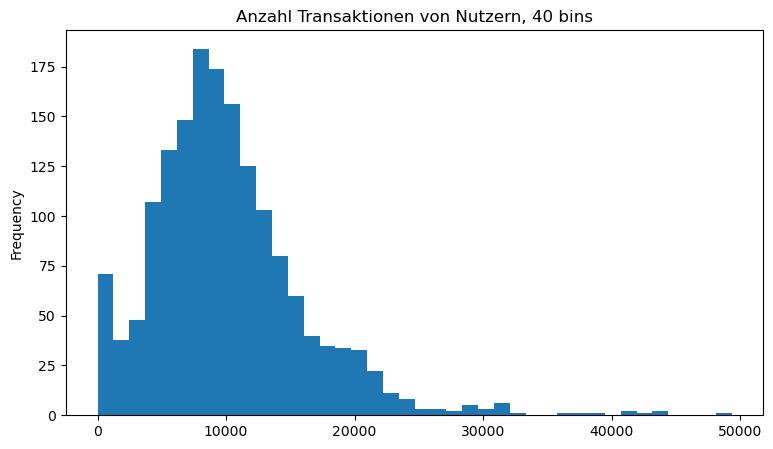

In [8]:
title = 'Anzahl Transaktionen von Nutzern, 40 bins'
data_pdf['anz_trx'].plot.hist(figsize=(9,5), bins= 40, title=title)

### Betrugsanteile/-quoten pro Jahr

In [9]:
sql ="""
with
  base(jahr, is_fraud) as (
    select 
      extract(year from ts),
      is_fraud
    from uccfraud.ccfraud2010
  ),
  proportion(jahr, anz_trx, ant_ok, ant_fraud) as (
    select 
      jahr,
      count(*),
      sum(case when is_fraud='No' then 1 else 0 end),
      sum(case when is_fraud='Yes' then 1 else 0 end)
    from base
    group by jahr
  ),
  ratio(jahr, anz_trx, ant_ok, ant_fraud, quote_ok, quote_fraud) as (
    select 
      jahr,
      anz_trx, 
      ant_ok, 
      ant_fraud,
      round(ant_ok*100/anz_trx::numeric, 4),
      round(ant_fraud*100/anz_trx::numeric, 4)
     from proportion 
  )
select
  jahr as "jahr",
  anz_trx as "anz_trx",
  ant_ok as "ant_ok",
  ant_fraud as "ant_fraud",
  quote_ok as "quote_ok",
  quote_fraud as "quote_fraud"
from ratio
order by jahr;"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
    data_pdf.jahr = data_pdf.jahr.astype('int32')
    data_pdf.set_index('jahr', inplace = True)
    
data_pdf

anz_trx   ant_ok  ant_fraud  quote_ok  quote_fraud
jahr                                                    
2010  1491225  1487390       3835   99.7428       0.2572
2011  1570551  1570496         55   99.9965       0.0035
2012  1610829  1609496       1333   99.9172       0.0828
2013  1650917  1648899       2018   99.8778       0.1222
2014  1672343  1671291       1052   99.9371       0.0629
2015  1701371  1698090       3281   99.8072       0.1928
2016  1708924  1705345       3579   99.7906       0.2094
2017  1723360  1723105        255   99.9852       0.0148
2018  1721615  1719124       2491   99.8553       0.1447
2019  1723938  1721851       2087   99.8789       0.1211

<AxesSubplot:title={'center':'Betrugsquote'}, xlabel='jahr', ylabel='prozent'>

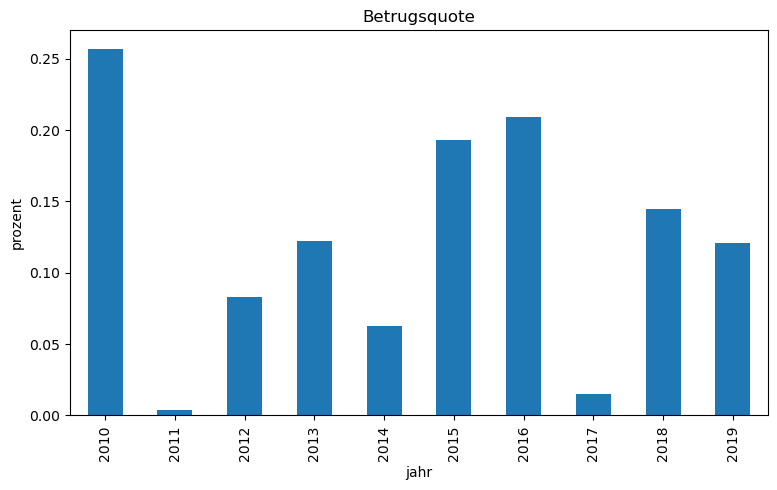

In [10]:
title = 'Betrugsquote'
xlabel = 'jahr'
ylabel='prozent'
data_pdf['quote_fraud'].plot.bar(figsize=(9,5), title=title, xlabel=xlabel, ylabel=ylabel)